In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=df73b1be17d82892b01699bbad6d4c2095d75a9a43d3d7fea394a276873d0b89
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


# **1. Importing Necessary Libraries** 📚

In [3]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os
import plotly.express as px

import warnings
warnings.filterwarnings("ignore") # to ignore warning messages
import itertools

import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from itertools import chain
from pyspark import SparkContext
from pyspark.sql import functions as F
from datetime import datetime
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.clustering import KMeans, GaussianMixture

In [4]:
spark= SparkSession.builder.master("local[1]").appName("final").getOrCreate() 


## Context

This dataset reflects incidents of crime in the City of Los Angeles dating back from 2010 to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0°, 0°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as th the data in the database.

## Attribute Description

**DR_NO:** Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits.

**API Field Name:** MM/DD/YYYY.

**DATE OCC:** MM/DD/YYYY.

**TIME OCC:** In 24 hour military time.

**AREA:** The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21.

**AREA NAME:** The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles.

**Rpt Dist No:** A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons.

**Crm Cd:** Indicates the crime committed. (Same as Crime Code 1)

**Crm Cd Desc:** Defines the Crime Code provided.

**Mocodes:** Modus Operandi: Activities associated with the suspect in commission of the crime.

**Vict Age:** Two character numeric.

**Vict Sex:** F - Female M - Male X - Unknown.

**Vict Descent:** Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian.

**Premis Cd:** The type of structure, vehicle, or location where the crime took place.

**Premis Desc:** Defines the Premise Code provided.

**Weapon Used Cd:** The type of weapon used in the crime.

**Weapon Desc:** Defines the Weapon Used Code provided.

**Status:** Status of the case. (IC is the default).

**Status DEsc:** Defines the Status Code provided.

**Crm Cd 1:** Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious.

**Crm Cd 2:** May contain a code for an additional crime, less serious than Crime Code 1.

**Crm Cd 3:** May contain a code for an additional crime, less serious than Crime Code 1.

**Crm Cd 4:** May contain a code for an additional crime, less serious than Crime Code 1.

**LOCATION:** Street address of crime incident rounded to the nearest hundred block to maintain anonymity.

**Cross Street:** Cross Street of rounded Address.

**LAT:** Latitude.

**LON:** Longitude.

# **2. Loading Dataset** 📊

In [7]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/drive/MyDrive/Applied Cloud Computing/Project/data/crimes_in_la.csv')
df.show(20)

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+-----

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
print('The shape of our data: %s crimes and %s features'%(df.count(),len(df.columns)))

The shape of our data: 317854 crimes and 28 features


In [9]:
print("Columns in our dataset: " , df.columns)
type(df)

Columns in our dataset:  ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


pyspark.sql.dataframe.DataFrame

# **3. Data Preprocessing (Cleaning)** 🧹

In [10]:
df = df.drop("Mocodes","DR_NO","Rpt Dist No", "LOCATION", "Date Rptd", "Part 1-2", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "Cross Street")

In [11]:
df.printSchema()

root
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)



In [12]:
df = df.withColumnRenamed("DATE OCC","Crime_date") \
    .withColumnRenamed("TIME OCC","Crime_time") \
    .withColumnRenamed("AREA","Area_cd") \
    .withColumnRenamed("AREA NAME","Area_name") \
    .withColumnRenamed("Crm Cd","Crime_cd") \
    .withColumnRenamed("Crm Cd Desc","Crime_cd_desc") \
    .withColumnRenamed("Vict Age","Vict_age") \
    .withColumnRenamed("Vict Sex","Vict_sex") \
    .withColumnRenamed("Vict Descent","Vict_descent") \
    .withColumnRenamed("Premis Cd","Premis_cd") \
    .withColumnRenamed("Premis Desc","Premis_desc") \
    .withColumnRenamed("Weapon Used Cd","Weapon_cd") \
    .withColumnRenamed("Weapon Desc","Weapon_desc") \
    .withColumnRenamed("Status Desc","Status_desc")
df.printSchema()

root
 |-- Crime_date: string (nullable = true)
 |-- Crime_time: integer (nullable = true)
 |-- Area_cd: integer (nullable = true)
 |-- Area_name: string (nullable = true)
 |-- Crime_cd: integer (nullable = true)
 |-- Crime_cd_desc: string (nullable = true)
 |-- Vict_age: integer (nullable = true)
 |-- Vict_sex: string (nullable = true)
 |-- Vict_descent: string (nullable = true)
 |-- Premis_cd: integer (nullable = true)
 |-- Premis_desc: string (nullable = true)
 |-- Weapon_cd: integer (nullable = true)
 |-- Weapon_desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status_desc: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)



In [13]:
from pyspark.sql.functions import col,isnan,when,count,asc,desc
null_values = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])

null_values.show()
df.count()

+----------+----------+-------+---------+--------+-------------+--------+--------+------------+---------+-----------+---------+-----------+------+-----------+---+---+
|Crime_date|Crime_time|Area_cd|Area_name|Crime_cd|Crime_cd_desc|Vict_age|Vict_sex|Vict_descent|Premis_cd|Premis_desc|Weapon_cd|Weapon_desc|Status|Status_desc|LAT|LON|
+----------+----------+-------+---------+--------+-------------+--------+--------+------------+---------+-----------+---------+-----------+------+-----------+---+---+
|         0|         0|      0|        0|       0|            0|       0|   41406|       41411|        5|        108|   201377|     201377|     0|          0|  0|  0|
+----------+----------+-------+---------+--------+-------------+--------+--------+------------+---------+-----------+---------+-----------+------+-----------+---+---+



317854

In [14]:
df = df.na.drop()
df.count()

116400

In [15]:
df = df.filter((df.Vict_age > 0) & (df.Vict_sex != 'null') & (df.Vict_sex != 'H') & (df.Vict_descent != 'null'))
df.count()

107448

In [16]:
crime_codes = df.groupBy('Crime_cd_desc').count().orderBy('count', ascending = False)
crime_codes.show(10, truncate = False)

+-------------------------------------------------------+-----+
|Crime_cd_desc                                          |count|
+-------------------------------------------------------+-----+
|BATTERY - SIMPLE ASSAULT                               |25669|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         |18605|
|INTIMATE PARTNER - SIMPLE ASSAULT                      |17138|
|ROBBERY                                                |9244 |
|CRIMINAL THREATS - NO WEAPON DISPLAYED                 |6564 |
|BRANDISH WEAPON                                        |5049 |
|INTIMATE PARTNER - AGGRAVATED ASSAULT                  |4672 |
|ATTEMPTED ROBBERY                                      |1581 |
|OTHER ASSAULT                                          |1559 |
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)|1517 |
+-------------------------------------------------------+-----+
only showing top 10 rows



In [17]:
victim = df.select(["Vict_age", "Vict_sex", "Vict_descent"])
victim.show()

+--------+--------+------------+
|Vict_age|Vict_sex|Vict_descent|
+--------+--------+------------+
|      36|       F|           B|
|      25|       M|           H|
|      25|       F|           H|
|      21|       F|           B|
|      29|       M|           A|
|      35|       M|           O|
|      21|       F|           W|
|      29|       F|           W|
|      68|       M|           B|
|      66|       M|           B|
|      24|       F|           W|
|      62|       M|           A|
|      71|       M|           W|
|      36|       X|           X|
|      19|       F|           B|
|      30|       M|           W|
|      69|       M|           B|
|      25|       M|           B|
|      37|       M|           B|
|      52|       M|           H|
+--------+--------+------------+
only showing top 20 rows



In [18]:
crimes_by_Area = df.groupBy('Area_name').count().orderBy('count', ascending=False)
crimes_by_Area.show()

+-----------+-----+
|  Area_name|count|
+-----------+-----+
|77th Street| 9813|
|  Southeast| 8318|
|    Central| 7492|
|  Southwest| 7410|
|     Newton| 6145|
|  Hollywood| 5924|
|    Rampart| 5858|
|    Olympic| 5491|
|    Pacific| 4918|
|     Harbor| 4621|
| Hollenbeck| 4402|
|    Mission| 4275|
|N Hollywood| 4180|
|   Wilshire| 4015|
|   Van Nuys| 3792|
|   Foothill| 3719|
|West Valley| 3601|
|    Topanga| 3584|
|  Northeast| 3543|
| Devonshire| 3207|
+-----------+-----+
only showing top 20 rows



In [19]:
df.select(['Vict_sex', 'Premis_desc', 'Weapon_desc']).rdd.map(lambda x: [x[0],x[1], x[2]]).take(10)


[['F',
  'SINGLE FAMILY DWELLING',
  'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)'],
 ['M', 'SIDEWALK', 'UNKNOWN WEAPON/OTHER WEAPON'],
 ['F', 'NIGHT CLUB (OPEN EVENINGS ONLY)', 'UNKNOWN WEAPON/OTHER WEAPON'],
 ['F', 'STREET', 'VERBAL THREAT'],
 ['M', 'STREET', 'ROCK/THROWN OBJECT'],
 ['M', 'PARKING LOT', 'VERBAL THREAT'],
 ['F', 'RESTAURANT/FAST FOOD', 'UNKNOWN WEAPON/OTHER WEAPON'],
 ['F', 'SIDEWALK', 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)'],
 ['M', 'DAM/RESERVOIR', 'AIR PISTOL/REVOLVER/RIFLE/BB GUN'],
 ['M', 'ALLEY', 'FOLDING KNIFE']]

In [20]:
df.groupBy('Vict_sex').count().orderBy('count', ascending=False).show()

+--------+-----+
|Vict_sex|count|
+--------+-----+
|       M|54064|
|       F|52541|
|       X|  843|
+--------+-----+



In [21]:
#df.filter((df.Area_name == "77th Street").groupby('Crime_cd_desc').count().orderBy('count', ascending=False)).show()
df.groupBy('Vict_descent').count().orderBy('count', ascending = False).show()

+------------+-----+
|Vict_descent|count|
+------------+-----+
|           H|52073|
|           B|25725|
|           W|18875|
|           O| 6932|
|           A| 2222|
|           X| 1277|
|           K|  199|
|           F|   58|
|           I|   27|
|           C|   14|
|           G|    9|
|           V|    9|
|           J|    8|
|           P|    6|
|           S|    5|
|           Z|    4|
|           U|    3|
|           L|    1|
|           D|    1|
+------------+-----+



In [22]:
df.filter(df['Area_name'] == '77th Street').groupBy("Weapon_desc", "Vict_descent").count().sort("count",ascending=False).show(10, truncate = False)

+----------------------------------------------+------------+-----+
|Weapon_desc                                   |Vict_descent|count|
+----------------------------------------------+------------+-----+
|STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)|B           |2406 |
|STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)|H           |2220 |
|HAND GUN                                      |B           |467  |
|VERBAL THREAT                                 |B           |339  |
|UNKNOWN FIREARM                               |B           |321  |
|UNKNOWN WEAPON/OTHER WEAPON                   |B           |321  |
|HAND GUN                                      |H           |271  |
|UNKNOWN WEAPON/OTHER WEAPON                   |H           |268  |
|VERBAL THREAT                                 |H           |264  |
|SEMI-AUTOMATIC PISTOL                         |B           |225  |
+----------------------------------------------+------------+-----+
only showing top 10 rows



In [23]:
df.select(['Crime_cd_desc', 'Vict_sex', 'Vict_age', 'Status_desc']).show(10, truncate = False)

+----------------------------------------------+--------+--------+-----------+
|Crime_cd_desc                                 |Vict_sex|Vict_age|Status_desc|
+----------------------------------------------+--------+--------+-----------+
|BATTERY - SIMPLE ASSAULT                      |F       |36      |Adult Other|
|BATTERY - SIMPLE ASSAULT                      |M       |25      |Invest Cont|
|RAPE, FORCIBLE                                |F       |25      |Invest Cont|
|CRIMINAL THREATS - NO WEAPON DISPLAYED        |F       |21      |Invest Cont|
|BURGLARY FROM VEHICLE                         |M       |29      |Invest Cont|
|CRIMINAL THREATS - NO WEAPON DISPLAYED        |M       |35      |Invest Cont|
|BATTERY - SIMPLE ASSAULT                      |F       |21      |Invest Cont|
|THEFT PLAIN - PETTY ($950 & UNDER)            |F       |29      |Invest Cont|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT|M       |68      |Invest Cont|
|ROBBERY                                       |M   

In [24]:
df.groupby(["Crime_cd_desc", "Vict_sex"]).agg(count("*").alias("count")).orderBy('count', ascending = False).show(truncate = False)

+-------------------------------------------------------+--------+-----+
|Crime_cd_desc                                          |Vict_sex|count|
+-------------------------------------------------------+--------+-----+
|BATTERY - SIMPLE ASSAULT                               |M       |13523|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         |M       |13420|
|INTIMATE PARTNER - SIMPLE ASSAULT                      |F       |12885|
|BATTERY - SIMPLE ASSAULT                               |F       |12075|
|ROBBERY                                                |M       |6276 |
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT         |F       |5007 |
|INTIMATE PARTNER - SIMPLE ASSAULT                      |M       |4240 |
|INTIMATE PARTNER - AGGRAVATED ASSAULT                  |F       |3571 |
|CRIMINAL THREATS - NO WEAPON DISPLAYED                 |F       |3421 |
|BRANDISH WEAPON                                        |M       |3335 |
|CRIMINAL THREATS - NO WEAPON DISPLAYED            

In [25]:
df.select(['Crime_date']).show(5, truncate = False)

+----------------------+
|Crime_date            |
+----------------------+
|01/08/2020 12:00:00 AM|
|01/01/2020 12:00:00 AM|
|01/01/2020 12:00:00 AM|
|09/12/2020 12:00:00 AM|
|01/04/2020 12:00:00 AM|
+----------------------+
only showing top 5 rows



In [26]:
myfunc =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
df = df.withColumn('Date_time', myfunc(col('Crime_date'))).drop("Crime_date")
df.select(df["Date_time"]).show(5)

+-------------------+
|          Date_time|
+-------------------+
|2020-01-08 00:00:00|
|2020-01-01 00:00:00|
|2020-01-01 00:00:00|
|2020-09-12 00:00:00|
|2020-01-04 00:00:00|
+-------------------+
only showing top 5 rows



In [27]:
df = df.withColumn('dayOfWeek', dayofweek(col('Date_time')))
df = df.withColumn('month', month(col('Date_time')))
df = df.withColumn('year', year(col('Date_time')))
df.select("dayOfWeek", "month", "year").show(10)

+---------+-----+----+
|dayOfWeek|month|year|
+---------+-----+----+
|        4|    1|2020|
|        4|    1|2020|
|        4|    1|2020|
|        7|    9|2020|
|        7|    1|2020|
|        1|    1|2020|
|        6|    3|2020|
|        7|    2|2020|
|        2|    9|2020|
|        3|    1|2020|
+---------+-----+----+
only showing top 10 rows



In [28]:
df.drop(col("Date_time")) \
  .printSchema() 


root
 |-- Crime_time: integer (nullable = true)
 |-- Area_cd: integer (nullable = true)
 |-- Area_name: string (nullable = true)
 |-- Crime_cd: integer (nullable = true)
 |-- Crime_cd_desc: string (nullable = true)
 |-- Vict_age: integer (nullable = true)
 |-- Vict_sex: string (nullable = true)
 |-- Vict_descent: string (nullable = true)
 |-- Premis_cd: integer (nullable = true)
 |-- Premis_desc: string (nullable = true)
 |-- Weapon_cd: integer (nullable = true)
 |-- Weapon_desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status_desc: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [29]:
df_breakdown = df.groupby(['month','year']).count().orderBy('year','month')
df_breakdown.show()


+-----+----+-----+
|month|year|count|
+-----+----+-----+
|    1|2020| 5967|
|    2|2020| 5681|
|    3|2020| 5266|
|    4|2020| 5021|
|    5|2020| 5520|
|    6|2020| 5717|
|    7|2020| 5794|
|    8|2020| 6130|
|    9|2020| 5690|
|   10|2020| 5726|
|   11|2020| 5213|
|   12|2020| 5098|
|    1|2021| 5034|
|    2|2021| 4721|
|    3|2021| 5081|
|    4|2021| 5184|
|    5|2021| 5570|
|    6|2021| 5731|
|    7|2021| 6412|
|    8|2021| 2892|
+-----+----+-----+



In [30]:
df.groupBy(["dayOfWeek", "Crime_time"]).agg(count("*").alias("count")).orderBy('count', ascending = False).show(truncate = False)

+---------+----------+-----+
|dayOfWeek|Crime_time|count|
+---------+----------+-----+
|7        |1200      |367  |
|7        |2200      |350  |
|4        |1200      |346  |
|5        |1200      |343  |
|1        |1200      |340  |
|6        |2100      |339  |
|1        |1700      |339  |
|7        |2100      |336  |
|1        |2000      |331  |
|6        |1200      |328  |
|7        |2000      |326  |
|2        |1200      |325  |
|7        |2300      |325  |
|3        |1200      |307  |
|1        |2100      |305  |
|6        |1900      |303  |
|5        |1800      |302  |
|1        |2200      |301  |
|7        |1700      |299  |
|1        |1800      |294  |
+---------+----------+-----+
only showing top 20 rows



In [31]:
crimes_per_hour =df.filter(df.Area_name.isin(["77th Street","Southeast", "Central"])).groupby('Area_name','Crime_time').count().orderBy('Area_name','Crime_time')
crimes_per_hour.show(20)

+-----------+----------+-----+
|  Area_name|Crime_time|count|
+-----------+----------+-----+
|77th Street|         1|  111|
|77th Street|         2|    1|
|77th Street|         3|    2|
|77th Street|         5|   39|
|77th Street|         6|    2|
|77th Street|        10|   36|
|77th Street|        12|    1|
|77th Street|        13|    1|
|77th Street|        15|   27|
|77th Street|        16|    1|
|77th Street|        17|    2|
|77th Street|        20|   23|
|77th Street|        25|   12|
|77th Street|        27|    1|
|77th Street|        30|   84|
|77th Street|        31|    1|
|77th Street|        33|    1|
|77th Street|        35|    7|
|77th Street|        37|    2|
|77th Street|        40|   17|
+-----------+----------+-----+
only showing top 20 rows



In [32]:
df.select(["LAT","LON"]).describe().show()

+-------+------------------+-------------------+
|summary|               LAT|                LON|
+-------+------------------+-------------------+
|  count|            107448|             107448|
|   mean|  33.8156735695406|-117.48690132996943|
| stddev|2.8844763130453033| 10.014661769578998|
|    min|               0.0|          -118.6652|
|    max|           34.3343|                0.0|
+-------+------------------+-------------------+



In [33]:
print(df.filter(df["Vict_sex"]=='M').count()/df.count() * 100)
print(df.filter(df["Vict_sex"]=='F').count()/df.count() * 100)

50.316432134613954
48.899002308093216


In [34]:
df.createOrReplaceTempView('crime_data')

In [35]:
sample = spark.sql('''
select
  * 
from crime_data 
limit 100
''')

sample.show(5)

+----------+-------+---------+--------+--------------------+--------+--------+------------+---------+--------------------+---------+--------------------+------+-----------+-------+---------+-------------------+---------+-----+----+
|Crime_time|Area_cd|Area_name|Crime_cd|       Crime_cd_desc|Vict_age|Vict_sex|Vict_descent|Premis_cd|         Premis_desc|Weapon_cd|         Weapon_desc|Status|Status_desc|    LAT|      LON|          Date_time|dayOfWeek|month|year|
+----------+-------+---------+--------+--------------------+--------+--------+------------+---------+--------------------+---------+--------------------+------+-----------+-------+---------+-------------------+---------+-----+----+
|      2230|      3|Southwest|     624|BATTERY - SIMPLE ...|      36|       F|           B|      501|SINGLE FAMILY DWE...|      400|STRONG-ARM (HANDS...|    AO|Adult Other|34.0141|-118.2978|2020-01-08 00:00:00|        4|    1|2020|
|       330|      1|  Central|     624|BATTERY - SIMPLE ...|      25|   

In [36]:
#incidents occured according to area code

incidents = spark.sql('''
select 
count(*) as Number_of_Crimes,
Area_cd
from crime_data
group by Area_cd
''')

incidents.show()

+----------------+-------+
|Number_of_Crimes|Area_cd|
+----------------+-------+
|            9813|     12|
|            7492|      1|
|            6145|     13|
|            5924|      6|
|            3719|     16|
|            7410|      3|
|            5491|     20|
|            4621|      5|
|            4275|     19|
|            4180|     15|
|            3207|     17|
|            3792|      9|
|            4402|      4|
|            3140|      8|
|            4015|      7|
|            3601|     10|
|            3584|     21|
|            3543|     11|
|            4918|     14|
|            5858|      2|
+----------------+-------+
only showing top 20 rows



In [37]:
# type of incidents occured according to area code

incidents_type = spark.sql('''
SELECT 
  COUNT(*) AS Number_of_Crimes,
  `Crime_cd`,
  `Area_cd`
FROM crime_data
GROUP BY `Area_cd`, `Crime_cd`
ORDER BY Number_of_Crimes DESC
''')

incidents_type.show()


+----------------+--------+-------+
|Number_of_Crimes|Crime_cd|Area_cd|
+----------------+--------+-------+
|            2205|     230|     12|
|            2172|     624|      1|
|            1837|     230|     18|
|            1645|     624|      3|
|            1572|     624|     12|
|            1550|     626|     12|
|            1517|     624|     20|
|            1443|     624|      2|
|            1442|     624|      6|
|            1419|     624|     13|
|            1398|     624|     18|
|            1293|     230|     13|
|            1282|     230|      1|
|            1266|     230|      3|
|            1224|     626|     18|
|            1190|     624|      4|
|            1167|     624|     15|
|            1159|     624|     14|
|            1149|     624|      5|
|            1140|     210|     12|
+----------------+--------+-------+
only showing top 20 rows



In [38]:
df.select([mean('Vict_age'), min('Vict_age'), max('Vict_age')]).show()

+------------------+-------------+-------------+
|     avg(Vict_age)|min(Vict_age)|max(Vict_age)|
+------------------+-------------+-------------+
|37.578158737249645|            2|           99|
+------------------+-------------+-------------+



In [39]:
df.filter(df['Vict_sex']== 'M').select([mean('Vict_age'), min('Vict_age'), max('Vict_age')]).show()

+------------------+-------------+-------------+
|     avg(Vict_age)|min(Vict_age)|max(Vict_age)|
+------------------+-------------+-------------+
|39.039786179343004|            2|           99|
+------------------+-------------+-------------+



In [40]:
df.filter(df['Vict_sex']== 'F').select([mean('Vict_age'), min('Vict_age'), max('Vict_age')]).show()

+-----------------+-------------+-------------+
|    avg(Vict_age)|min(Vict_age)|max(Vict_age)|
+-----------------+-------------+-------------+
|36.26366076016825|            2|           99|
+-----------------+-------------+-------------+



In [41]:
df.select(['Vict_sex', 'Vict_age']).groupby('Vict_sex').agg(mean('Vict_age')).show()

+--------+------------------+
|Vict_sex|     avg(Vict_age)|
+--------+------------------+
|       F| 36.26366076016825|
|       M|39.039786179343004|
|       X| 25.76749703440095|
+--------+------------------+



# **4. Exploratory Data Analysis** 📉

In [42]:
pandas_df = df.toPandas()

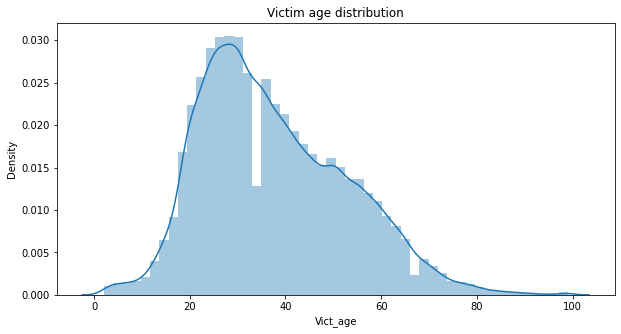

In [43]:
plt.figure(figsize=(10,5))
plt.title('Victim age distribution')
sns.distplot(pandas_df['Vict_age']);

In [44]:
px.histogram(pandas_df, x="Vict_descent", width=1200, height=600, title="Visualizaton of Crime w.r.t Victim descent")

In [45]:
df3 = pandas_df[pandas_df["Area_name"] == "Hollywood"]
fig = px.histogram(df3, x="Weapon_desc", width=600, height=400, title="Weapons used for crime in Hollywood") 
fig.show()

# **5. Feature Engineering** ⚙️

In [46]:
Variable_idx= [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ["Vict_sex", "Vict_descent"]]
indexer_pipeline = Pipeline(stages=Variable_idx)
df = indexer_pipeline.fit(df).transform(df)

encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded") for column in ["Vict_sex", "Vict_descent"]]
encoder_pipeline = Pipeline(stages=encoders)
df = encoder_pipeline.fit(df).transform(df)

assembler = VectorAssembler(inputCols=['Vict_age', 'Vict_descent_encoded', 'Area_cd', 'Vict_sex_encoded', 'Premis_cd', 'Weapon_cd', 'Crime_time'], outputCol="features")

df_features = assembler.transform(df)
indexer = StringIndexer(inputCol='Crime_cd', outputCol='label')

index_model = indexer.fit(df_features)
final_set = index_model.transform(df_features).select("features", "label")
final_set.show()


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(25,[0,2,19,21,22...|  0.0|
|(25,[0,1,19,20,22...|  0.0|
|(25,[0,1,19,21,22...| 12.0|
|(25,[0,2,19,21,22...|  4.0|
|(25,[0,5,19,20,22...| 13.0|
|(25,[0,4,19,20,22...|  4.0|
|(25,[0,3,19,21,22...|  0.0|
|(25,[0,3,19,21,22...| 20.0|
|(25,[0,2,19,20,22...|  1.0|
|(25,[0,2,19,20,22...|  3.0|
|(25,[0,3,19,21,22...|  5.0|
|(25,[0,5,19,20,22...|  1.0|
|(25,[0,3,19,20,22...|  1.0|
|(25,[0,6,19,22,23...| 22.0|
|(25,[0,2,19,21,22...| 12.0|
|(25,[0,3,19,20,22...| 27.0|
|(25,[0,2,19,20,22...|  4.0|
|(25,[0,2,19,20,22...|  2.0|
|(25,[0,2,19,20,22...|  4.0|
|(25,[0,1,19,20,22...|  1.0|
+--------------------+-----+
only showing top 20 rows



# **6. Building Machine Learning Model** 🤖

In [47]:
train, test = final_set.randomSplit([0.7, 0.3], seed = 1)

print(train.count(), test.count())

75146 32302


# **Logistic Regression** 

In [48]:
# Define the feature columns
feature_cols = final_set.columns[:-1]

# Train a logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train)
lrn_summary = lr_model.summary
lrn_summary.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(25,[0,1,19,20,22...| 19.0|[6.13154402698465...|[0.02999022113015...|      14.0|
|(25,[0,1,19,20,22...| 26.0|[6.57188068904106...|[0.01312352981264...|      14.0|
|(25,[0,1,19,20,22...| 36.0|[7.33588415849920...|[0.01270604255771...|       1.0|
|(25,[0,1,19,20,22...| 14.0|[6.34103543785769...|[0.01095599713545...|      14.0|
|(25,[0,1,19,20,22...| 18.0|[6.35481669886154...|[0.00980474891309...|      14.0|
|(25,[0,1,19,20,22...|  1.0|[7.26517338802940...|[0.01114121728553...|       1.0|
|(25,[0,1,19,20,22...| 53.0|[6.13153260930406...|[0.02595547935384...|      14.0|
|(25,[0,1,19,20,22...| 14.0|[6.54349649873940...|[0.01069089233999...|      14.0|
|(25,[0,1,19,20,22...|  1.0|[7.21552301274386...|[0.01209358800684...|       1.0|
|(25,[0,1,19,20,

In [49]:
# Evaluate the model on the testing data
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label")
test_results = lr_model.transform(test)
auc = evaluator.evaluate(test_results)
print(f"Test AUC: {auc}")

Test AUC: 0.677386783358603


In [50]:
# Evaluate the model using BinaryClassificationEvaluator for ROC_AUC score
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator_auc.evaluate(test_results)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy score
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(test_results)

# Evaluate the model using RegressionEvaluator for variance score
evaluator_var = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
variance = evaluator_var.evaluate(test_results)

print("Variance Score: {}".format(variance))
print("Accuracy Score: {}".format(accuracy))
print("ROC_AUC Score: {}".format(roc_auc))


Variance Score: -0.12125123121717962
Accuracy Score: 0.4201597424308092
ROC_AUC Score: 0.677386783358603


In [51]:
# Define the evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")

# Calculate the evaluation metrics
precision = evaluator.evaluate(test_results, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(test_results, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(test_results, {evaluator.metricName: "f1"})
print("F1 Score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall Score: {}".format(recall))

F1 Score: 0.33589121868736893
Precision: 0.33375137865313703
Recall Score: 0.4201597424308092


# **Random Forest Classifier** 

In [52]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rf.fit(train)

prediction = rfModel.transform(test)
prediction_rdd = prediction.select("prediction", "label").rdd.map(tuple)
prediction_rdd.take(2)

[(0.0, 53.0), (0.0, 14.0)]

In [53]:
metrics = MulticlassMetrics(prediction_rdd)
metrics.accuracy

0.4502198006315398

# **K-means Clustering** 

In [54]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(train)

# Make predictions
predictions = model.transform(train)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7017258258073333
Cluster Centers: 
[3.74484303e+01 4.96455497e-01 2.29931360e-01 1.72454147e-01
 6.46112299e-02 2.08619332e-02 1.25576685e-02 1.66535389e-03
 5.85124339e-04 2.92562169e-04 9.00191291e-05 6.75143468e-05
 1.12523911e-04 9.00191291e-05 9.00191291e-05 4.50095645e-05
 2.25047823e-05 4.50095645e-05 2.25047823e-05 1.07130190e+01
 5.10138404e-01 4.81647350e-01 3.05382131e+02 3.63085676e+02
 1.82970827e+03]
[3.78064537e+01 4.68952493e-01 2.52124646e-01 1.79414542e-01
 6.36905343e-02 2.12953014e-02 1.12988831e-02 1.92113575e-03
 4.23301097e-04 1.95369737e-04 1.95369737e-04 9.76848686e-05
 9.76848686e-05 6.51232457e-05 0.00000000e+00 6.51232457e-05
 9.76848686e-05 3.25616229e-05 0.00000000e+00 1.04109277e+01
 4.93048094e-01 4.99723226e-01 3.21283970e+02 3.66977011e+02
 6.79686725e+02]


# **Gaussian Mixture** 

In [55]:
gmm = GaussianMixture().setK(2)
model = gmm.fit(train)

print("Gaussians: ")
model.gaussiansDF.show()

Gaussians: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[37.7858476474981...|286.4871858199449...|
|[37.5876869790804...|230.5906026534674...|
+--------------------+--------------------+

